In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "fantasy"
plt.rcParams["axes.linewidth"] = 1.5

# Adding Error Bars to 5-Star Reviews: A Bayesian Approach
*Picking the right color sock 🧦 using PyMC3*

When you're shopping for a new pair of socks online you would naturally look for the ones with the highest review scores. And very often you see items with 5-star ⭐⭐⭐⭐⭐ reviews ️️️️show up on your search query. But how willing are you to buy a pair of socks with a 5-star review from only two users? Would you pick that over a pair with an average of 4.5 stars out of 100 reviews? Perhaps not, but why? Although you know that 5 is definitely greater than 4.5, there is something about only having two reviews that makes you hesitate. 

When the number of reviews is small, you have every right to be doubtful about the validity of the rating. These ratings are just a number (an average) without any statistical uncertainty. If I tell you that the average height of my two cousins is 3' 5" (~100 cm) that doesn't really tell you much. Are they both preschoolers with the same height, or is one of them a basketball champion and the other one a toddler? Averages of small number of observations are usually not that informative because they can carry huge uncertainties. 

The situation is somewhat similar with the two 5-star reviews, but there is a way to remedy that. Aside from the average, 5, we know the distribution (think histogram of the reviews) as well. The goal of this article is to show how using Bayesian statistics we can translate the number of reviews, or more precisely their distribution, to infer the uncertainty about the true rating. Do you need to buy a new pair of socks and don't know how much you can trust the item with two 5-star reviews? Here we'll learn how to attach error bars to those reviews and use them to rank various pairs in our search query.

# Model

I am going to model each review as a series of coin tosses - this is an article on statistics after all!

For clarity, I will use the word *review* to refer to individual score for the product, and the word *rating* for the average of all user reviews; An individual review score can be an integer between 1 to 5 (e.g. a 3 or 4) but the rating can be a real number in that same range (e.g. 3.8). According to the law of large numbers, the observed rating should converge to the *true rating* of the product. Obviously, here I am making a few implicit assumptions, namely (1) the item has a true objective rating (based on quality, fairness of price, etc.) and (2) that all the user reviews are honest; the latter assumption clearly does not apply to most real-life reviews which could contain paid or fake reviews.

Back to the model: let's assume that each customer decides the review score for the socks using four tosses of a biased coin. Each time the coin lands heads, one star is added, if it lands tails no star is added. The better the product, the higher the bias of the coin p(the probability of heads).

Why four tosses and not five? The minimum rating for the items is one star (we don't have 0-star reviews), so that leaves us with only four coin flips. The sum of the number of observed heads plus 1 (the first coin) gives us the final review score for the socks. For example the sequence H, T, H, H is equivalent to a 4-star review and T, H, T, T results in 2 stars. In this model each review is essentially a result of a Binomial process where the probability of the outcome can be expressed with the binomial distribution as

\begin{equation}\label{eq:Bern}
    P(\textrm{review}=k+1|n,p) = {n \choose k } p^k (1-p)^{n-k}.
\end{equation}

where $p$ is the bias of the coin, $n$ is the total number of flips (here 4), and $k$ is the number of observed heads. The 1 in $k+1$ is added to fix the rating scale which starts from 1 instead of a 0. The key assumption in this model is that the bias of the coin $p$ is related to the true rating of the product such that $p=0$ always results in the coin landing tails or equivalently 1-star rating (terrible product) and $p=1$ always results in heads which means 5-star ratings (awesome product). Meanwhile, p=0.5 results in an average of two heads per toss corresponding to a 3-star rating (average product). To comfort yourself mathematically, you can use the mean of the binomial distribution np, which for $p = [0, 0.5, 1]$ respectively yields 1, 3, and 5 ratings (I've added the extra 1 here). Let's confirm this using some python code:

In [2]:
import numpy as np

p = np.array([0, .5, 1])
n_toss = 4
n_reviews = 1000

avg_rating = [1 + np.mean(np.random.binomial(n_toss, p_, size=n_reviews)) for p_ in p]

print(avg_rating)

[1.0, 3.039, 5.0]


Great! Now we can use this model to generate some mock data to play with. Before we move on, I am going to define a scaler object that converts ratings to probabilities and vice versa. Our observable is the rating (average of reviews) which ranges between 1 to 5, but we would ultimately perform inference on the probability $p$ ranging between 0 to 1. So it'll be useful to have an easy way to translate back and forth between the two.  

In [3]:
class RatingScaler:
    """convert a rating ranging between min_rating to max_rating 
    to a probability ranging between 0 to 1"""
    
    def __init__(self, min_rating=1, max_rating=5):
        
        assert (int(min_rating) == min_rating) and int(max_rating) == max_rating,\
                "min_rating and max_rating must be integers"
        
        self.offset = min_rating
        self.n = max_rating - min_rating
        
    def r2p(self, r):
        """convert rating [min_rating, max_rating] to probability [0, 1]"""
    
        return (r-self.offset)/self.n
    
    def p2r(self, p):
        """convert probability [0,1] to rating [min_rating, max_rating]"""
    
        return p * self.n + self.offset
    
      
#let's test the r2p method
scaler = RatingScaler(min_rating=1, max_rating=5)

ratings = np.array([1, 2, 3, 4, 5])
scaler.r2p(np.array(ratings))


array([0.  , 0.25, 0.5 , 0.75, 1.  ])

## Data Generation: Mock Sock Reviews

Now that we have a generative model for the ratings, we can use it to generate mock data. To simulate the reviews for each product all we need is the number of reviews and the true rating of the item which determines the true bias of the coin $p$. Each review is the sum of the observed heads in four (biased) coin tosses, so all we need to do is to draw random numbers from a binomial distribution with parameters $n=4$ and `p=scaler.r2p(true rating)`. 

Let's follow these steps to generate some mock sock reviews! To make things easy, I'm going to create a Sock dataclass with three main attributes: `n_reviews`, `true_rating`, and `color`.   

In [4]:
from dataclasses import dataclass

@dataclass(frozen=True)
class Sock:
    
    n_reviews: int     # number of reviews to generate
    true_rating: float # objective rating of the product 
    color: str         # color of the socks!
    n_toss: int = 4    # number of times we toss coins to generate each review 
                       # (parameter n in the binomial distribution)
    
    @property
    def avg_rating(self):
        """average of all the generated reviews"""
        return np.mean(self.reviews)
    
    @property
    def true_p(self):
        """true_rating transformed to a probability
        parameter p in the binomial distribution"""
        return scaler.r2p(self.true_rating)
    
    @property
    def avg_p(self):
        """avg_rating transformed to a probability"""
        return scaler.r2p(self.avg_rating)
    
    @property
    def reviews(self):
        """list of simulated reviews"""
        np.random.seed(60) # I'll explain this in a bit
        return np.random.binomial(self.n_toss, self.true_p, size=self.n_reviews)+1

Cool! Now, let's say we have three different types of socks on the menu: blue, orange, and red.

In [5]:
socks = [Sock(n_reviews=20, true_rating=3.2, color="tab:blue"),
         Sock(n_reviews=2  , true_rating=4.0, color="tab:orange"),
         Sock(n_reviews=100, true_rating=4.5, color="tab:red")]

n_socks = len(socks)

I have assigned the true ratings of 3.2, 4.0, and 4.5 to these items i.e. the blue socks are ok, the orange ones are good, and the red pair is great! Our goal as a sock shopper is to buy the best pair of socks we can find out there, but the problem is that the true rating of these items are not observable. The only thing that you can observe is a statistical estimate of the true rating a.k.a. the average customer rating. The average rating is a good estimate of the true rating if wee have a lot of reviews, but what if we don't?

In this example, we have assumed that the orange socks (4.0 stars) are objectively inferior to the red ones (4.5 stars) but imagine that the only two costumers who bought the orange pair for some reason were super excited about their purchase and decided to give it 5 stars (this means that all their coins randomly landed heads). In this case, the average rating of 5 (which we see) would be larger than the true rating of 4.0 (which we don't see). So by comparing the average ratings, we would draw the incorrect conclusion that the orange pair is superior to the red pair. 

 To simulate this, I'm going to cheat and choose the seed of the random number generator so that both reviews for the orange socks end up as 5-stars (this is already implemented in the Sock data class). Let's have a quick look at the normalized histogram of all the reviews.

/Users/siavashyasini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


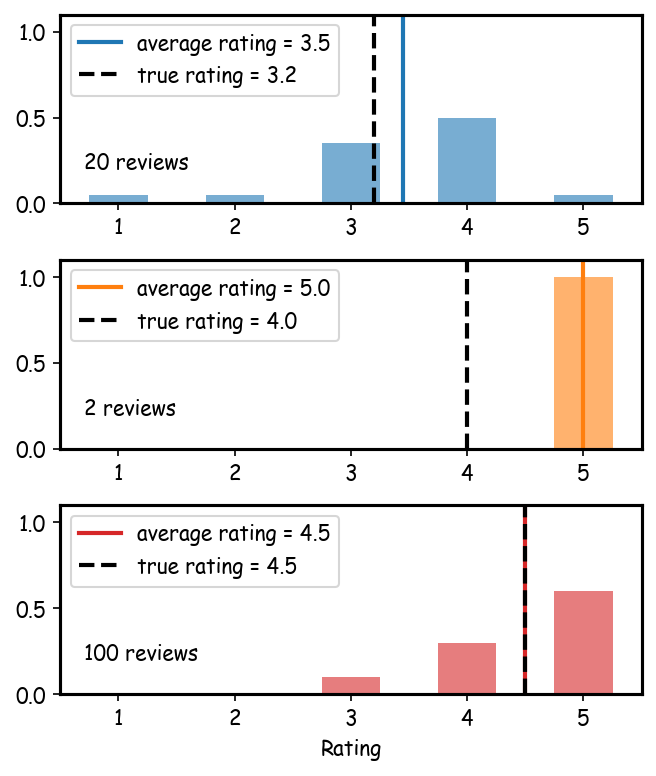

In [6]:
fig, ax = plt.subplots(n_socks,1, figsize=(5,6),dpi=150)

for i, item in enumerate(socks):
    #x=np.arange(len(ratings[i]))
    ax[i].hist(item.reviews, bins =[1, 2, 3, 4, 5, 6] , normed=True, rwidth=0.5, align="left", color=item.color, alpha=0.6)

    ax[i].axvline(item.avg_rating, color=item.color,lw=2, label=f"average rating = {item.avg_rating:.1f}")
    ax[i].axvline(item.true_rating, color="k", ls="--",lw=2, label=f"true rating = {item.true_rating:.1f}")
    ax[i].text(.7,0.2, f"{item.n_reviews} reviews")
    ax[i].legend(loc=2)
    ax[i].set_xlim(0.5,5.5)
    ax[i].set_ylim(0,1.1)
    
ax[2].set_xlabel("Rating")
plt.subplots_adjust(hspace=.3)

plt.savefig("review_histograms.png", dpi=150, bbox_inches="tight")

The dashed lines are the underlying true ratings and the solid lines are the average of all reviews. Remember that the true ratings, which are not subject to randomness, are unobservable. The goal here is to pick the pair of socks with the highest true rating. As you can from the plot, if we go by the highest average rating and pick the orange pair we would be making a mistake, but how can we adjust our metric to pick the correct color?

# Bayesian Inference 

Perhaps not surprisingly, I'm going to use the Bayes' theorem to infer the true rating of the socks using the observational data as evidence. We want to find the true rating of each product, given all the user reviews:

\begin{equation}
P(\textrm{true rating} | \textrm{reviews} ) = \frac{P( \textrm{true rating}) \times \prod_i P( \textrm{review}_i|\textrm{true rating} ) }{P( \textrm{reviews})}
\end{equation}


The first term in the numerator on the right-hand side is the prior (our initial belief on the distribution of true rating) and the second term is the likelihood. To be conservative, we can use a flat prior for the rating, that is to say, we assume that *before seeing any of the reviews* it's equally likely for the socks to have any rating between 1 to 5 stars. The likelihood for each individual review is a binomial distribution shown in Eq. 1 above, so to construct the full likelihood we only need to replace each k with the observed review score and multiply everything together. Remember that there is a one-to-one mapping between the bias of the coin $p$ (see Eq 1.) and true rating (Eq. 2) and I'm using them interchangeably.

In order to find the probability distribution of the true rating of each item, I'm going to use `PyMC3` to sample their posteriors. The following function takes in an instance of the Sock object and returns the MCMC samples from the posterior in Eq. 2. Going over the details of how `PyMC3` works is beyond the scope of this article but feel free to ask questions in the comment section or post issues on the Github Repo if anything is confusing.

In [7]:
import pymc3 as pm

def get_posterior(sock, steps=10000, burn_in=2000):
    
    n_toss = sock.n_toss  
    reviews = sock.reviews-1  # subtract 1 to adjust for the first star
    n = n_toss * np.ones_like(reviews) 
    
    with pm.Model() as model: 
    
        # flat prior
        p = pm.Beta("p", alpha=1, beta=1) # uniform prior
    
        # Likelihood
        score = pm.Binomial("score", n=n, p=p, observed=reviews)
        
        start = pm.find_MAP()
        trace = pm.sample(steps, start=start)
        
    return trace[burn_in:]

*Note: In the prior section of the above function I've used a Beta function notation for p because its the conjugate prior to the binomial distribution. This is technically unnecessary since we're not solving this problem analytically but I did it anyway so I could write this little note about it!*


Now let's sample the posterior for all the socks and find the mean and standard deviation of the probability distributions. 

In [8]:
posteriors = [get_posterior(sock) for sock in socks]

# the PyMC3 sampler samples p, but we want the mean and std of the rating 
# here I'm using the scaler object to transform them back 
means = [scaler.p2r(posterior["p"].mean()) for posterior in posteriors]
std_errs = [scaler.p2r(posterior["p"].std())-1 for posterior in posteriors]

logp = -27.66, ||grad|| = 9: 100%|██████████| 6/6 [00:00<00:00, 416.87it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:07<00:00, 2895.49draws/s]
logp = -0.0031509, ||grad|| = 0.0031503: 100%|██████████| 21/21 [00:00<00:00, 2835.08it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:09<00:00, 2233.38draws/s]
logp = -217.75, ||grad|| = 150: 100%|██████████| 9/9 [00:00<00:00, 2441.07it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:07<00:00, 2917.06draws/s]


Now in addition to an average, we have a standard deviation too! We can add this to the original histogram as error bars (I'm being a bit careless here simply adding the std error around the mean which is not strictly speaking correct for non-normal data). Here is what it looks like:

/Users/siavashyasini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


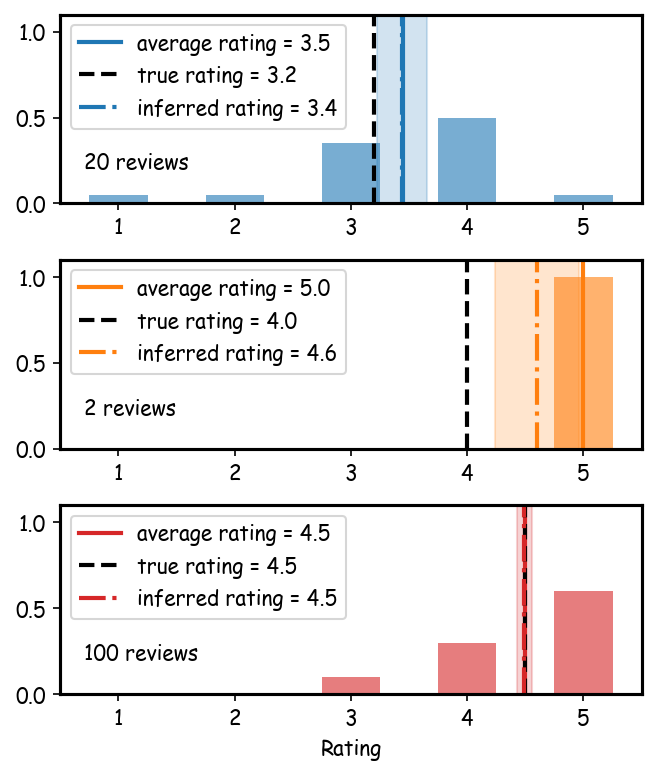

In [9]:
fig, ax = plt.subplots(n_socks,1, figsize=(5,6),dpi=150)

confidence = [(mean-std_err, mean+std_err) for mean, std_err in zip(means, std_errs)]

for i, item in enumerate(socks):

    ax[i].hist(item.reviews, bins =[1, 2, 3, 4, 5, 6] , normed=True, rwidth=0.5, align="left", color=item.color, alpha=0.6)
    
    ax[i].axvline(item.avg_rating,  color=item.color,lw=2., label=f"average rating = {item.avg_rating:.1f}")
    ax[i].axvline(item.true_rating, color="k", ls="--",lw=2., label=f"true rating = {item.true_rating:.1f}")
    ax[i].axvline(means[i],  color=item.color,lw=2., ls="-.", label=f"inferred rating = {means[i]:.1f}")
    ax[i].fill_betweenx(np.linspace(0,2,20), *confidence[i],  color=item.color, alpha=0.2)
    ax[i].text(.7,0.2, f"{item.n_reviews} reviews")
    
    ax[i].legend(loc=2)
    
    ax[i].set_xlim(0.5,5.5)
    ax[i].set_ylim(0,1.1)

ax[2].set_xlabel("Rating")
plt.subplots_adjust(hspace=.3)

plt.savefig("review_histograms_error.png", dpi=150, bbox_inches="tight")


As expected, the socks with a larger number of reviews have smaller error bars. Very interesting, but maybe not as informative as we hoped. The inferred rating for the orange socks with only 2 reviews is still larger than the inferred rating of the red one with 100 reviews. Then how do we pick the correct pair?

Let's check out the KDE of the posterior to see the actual shape of the distribution. This plot shows the posterior probability of the true rating for each pair which is: our initial belief of what the rating might be (uniform probability of all ratings in this case) updated based on the likelihood of the observation of the user reviews (binomial likelihood of Eq. 1).

In [10]:
from scipy import stats
from scipy.stats.mstats import mquantiles

In [11]:
kde = [stats.gaussian_kde(scaler.p2r(posteriors[i]["p"])) for i in range(3)]
x = np.linspace(0,5,300)
mean_ticks = [scaler.p2r(stats.mstats.mquantiles(posteriors[i]["p"], 0.5)) for i in range(3)]

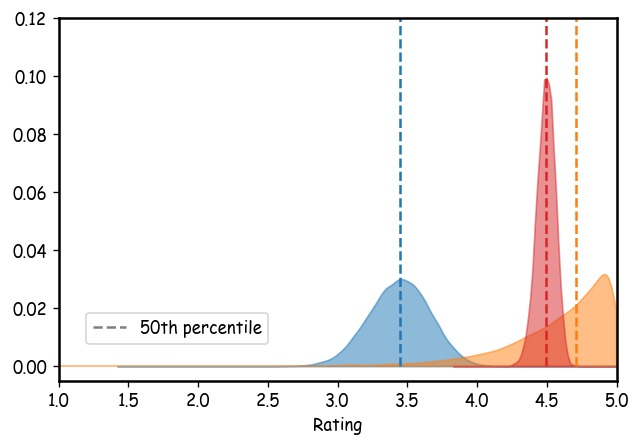

In [12]:
plt.figure(figsize=(6,4), dpi=120)
y = [kde[i](x)/kde[i](x).sum() for i in range(3)]

for i, item in enumerate(socks):
    plt.fill_between(x, y[i], where=y[i]>0, color=item.color, alpha=0.5,)
    plt.vlines(mean_ticks[i], 0,1, ls="--", color=item.color)
    

custom_lines = [Line2D([0], [0], ls="--", color="grey",)]
plt.legend(custom_lines, ['50th percentile'], loc=(0.05, 0.1))                
             
plt.xlabel("Rating")
plt.xlim(1,5)
plt.ylim(-0.005,0.12)

plt.savefig("review_kde.png", dpi=150, bbox_inches="tight")


Let's make a few observations here. Just as a reminder, the (blue, orange, red) socks with the true ratings of (3.2, 4.0, 4.5) each had (20, 2, 100) reviews. First, we see that the width of the posterior PDFs are inversely proportional to the number of reviews for each item: the more reviews we have, the less uncertain we are about the final estimate of the true rating. Second, the peak of the blue and red PDFs are pretty close to the true ratings, but for the orange pair not so much. This makes sense because for the orange socks we only had 2 observations which are not very limiting. The long tail of the orange posterior admits to the fact that it's very uncertain about the final result. But still, it's giving us the information that we were looking for in this analysis.

What if instead of using the mean of the posteriors (50th percentile) to rank the socks - as we did in the second plot - we use the 5th percentile? This way we are 95% sure that the true rating lies above this number. With this ranking stratergy either if the socks have lower ratings or if they have a smaller number of reviews - which means a wider tail in the distribution - they will sink lower in the list. Using the 5th percentile for our posterior PDFs results in the following ordering:

In [13]:
ticks = [scaler.p2r(stats.mstats.mquantiles(posteriors[i]["p"], 0.05)) for i in range(3)]

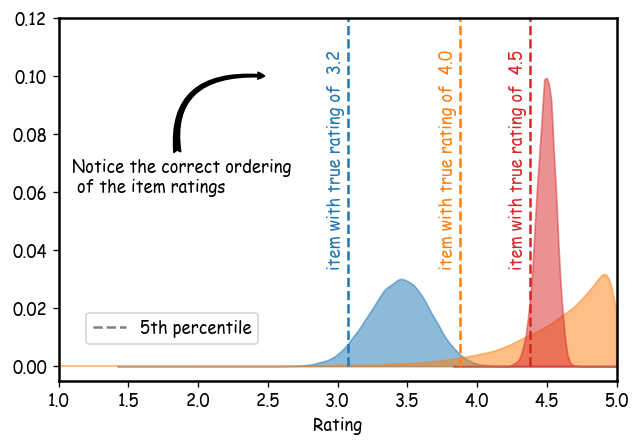

In [14]:
plt.figure(figsize=(6,4), dpi=120)
y = [kde[i](x)/kde[i](x).sum() for i in range(3)]

for i, item in enumerate(socks):
    plt.fill_between(x, y[i], where=y[i]>0, color=item.color, alpha=0.5,)
    plt.vlines(ticks[i], 0,1, ls="--", color=item.color)
    plt.text(ticks[i]-0.15, 0.035, f"item with true rating of  {socks[i].true_rating}", rotation=90, color=item.color)

plt.annotate("Notice the correct ordering\n of the item ratings", (2.5, 0.1), xytext=(1.1,0.06), 
             arrowprops={"arrowstyle": "fancy", "connectionstyle":"arc3,rad=-0.7", "color":'k'})

custom_lines = [Line2D([0], [0], ls="--", color="grey",)]
plt.legend(custom_lines, ['5th percentile'], loc=(0.05, 0.1))                
             
plt.xlabel("Rating")
plt.xlim(1,5)
plt.ylim(-0.005,0.12)

plt.savefig("review_kde_ranked.png", dpi=150, bbox_inches="tight")


Voila!

And that's it… Now that we've added error bars to our socks, we can confidently buy the best pair. And that's definitely what Reverend Thomas Bayes would have done!


**Important Note**: Do not attempt to implement this analysis in real life. Socks or other types of undergarments purchased solely based on the results of this analysis might not match the rest of your outfit.